In [1]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import glob
import itertools
from collections import namedtuple

import matplotlib.ticker as ticker

import sys
from paths import Paths
paths = Paths()
sys.path.append(paths.scripts_root)
import util

%load_ext autoreload
%autoreload 2

# Display entire width of browser
from IPython.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

paths.print_paths()

Paths defined in paths module:
 paths.data_root: /Users/trafferty/data
 paths.notebook_root: /Users/trafferty/data/notebooks
 paths.scripts_root: /Users/trafferty/data/scripts
 paths.images_root: /Users/trafferty/data/images
 paths.projects_root: /Users/trafferty/data/projects
 paths.results_root: /Users/trafferty/data/results
 paths.tmp_root: /Users/trafferty/data/tmp
 paths.dat_root: /Users/trafferty/data/dat
 paths.tmp_dir: /Users/trafferty/tmp
 paths.ws_dir: /Users/trafferty/workspace
 paths.mii_home: /Users/trafferty/dev
 paths.inhouse: /Users/trafferty/dev/src/inhouse


In [2]:
result_path = f"{paths.tmp_dir}/DIF/DIF1_Jason_Qi_long_test"

ip_results_df = pd.read_csv(f"{result_path}/full_results_0.csv")
image_stats_df = pd.read_csv(f"{result_path}/image_stats.csv")

In [3]:
# Fix the Velocity, Vol_top and Vol_bot series (convert to float, replace 'n/a' with NaN)
for field in ['Velocity', 'Vol_top', 'Vol_bot']:
    ip_results_df[field] = pd.to_numeric(ip_results_df[field], errors='coerce')

In [104]:
# Fix the image stat column names
image_stats_df.columns = [field.strip() for field in image_stats_df.columns]
image_stats_df.columns

Index(['LoopID', 'ImageFile', 'Top Saturation', 'Top Min', 'Top Max',
       'Top Mean', 'Bot Saturation', 'Bot Min', 'Bot Max', 'Bot Mean'],
      dtype='object')

In [4]:
Stats = namedtuple('Stats', 'n mean std var')

def get_stats(ip_df, print_stats = False):
    stats = {}
    stats['Velocity'] = Stats(ip_df['Velocity'].count(), np.mean(ip_df['Velocity']), np.std(ip_df['Velocity']), np.var(ip_df['Velocity']))
    stats['Vol_top']  = Stats(ip_df['Vol_top'].count(), np.mean(ip_df['Vol_top']),  np.std(ip_df['Vol_top']),  np.var(ip_df['Vol_top']))
    stats['Vol_bot']  = Stats(ip_df['Vol_bot'].count(), np.mean(ip_df['Vol_bot']),  np.std(ip_df['Vol_bot']),  np.var(ip_df['Vol_bot']))
    if print_stats:
        print("             num  \tMean \tStdev \tVariance")
        print(f" Velocity:   {stats['Velocity'].n:5}\t{stats['Velocity'].mean:.3f}\t{stats['Velocity'].std:.3f} \t{stats['Velocity'].var:.3f}")
        print(f" Vol_top :   {stats['Vol_top'].n:5}\t{stats['Vol_top'].mean:.3f}\t{stats['Vol_top'].std:.3f} \t{stats['Vol_top'].var:.3f}")
        print(f" Vol_bot :   {stats['Vol_bot'].n:5}\t{stats['Vol_bot'].mean:.3f}\t{stats['Vol_bot'].std:.3f} \t{stats['Vol_bot'].var:.3f}")
    return stats

In [14]:
s =get_stats(ip_results_by_nozzle_df[300], True)

             num  	Mean 	Stdev 	Variance
 Velocity:    9971	5.420	0.080 	0.006
 Vol_top :    9971	0.738	0.122 	0.015
 Vol_bot :    9971	0.693	0.135 	0.018


In [7]:
image_stats_df.head()

,LoopID,ImageFile,Top Saturation,Top Min,Top Max,Top Mean,Bot Saturation,Bot Min,Bot Max,Bot Mean
0,1,/media/DIF_DATA/images/2536865/2019-05-09_10.3...,0.470187,2631,65254,30814.199414,0.378838,2162,65535,24827.537878
1,2,/media/DIF_DATA/images/2536865/2019-05-09_10.3...,0.471469,2692,65535,30898.204485,0.375421,2210,65515,24603.591136
2,3,/media/DIF_DATA/images/2536865/2019-05-09_10.3...,0.461924,2704,65535,30272.637928,0.381119,2434,65443,24977.029797
3,4,/media/DIF_DATA/images/2536865/2019-05-09_10.3...,0.458772,2825,65535,30066.097748,0.381409,2486,65278,24995.994272
4,5,/media/DIF_DATA/images/2536865/2019-05-09_10.3...,0.465921,2889,65535,30534.619410,0.375223,2465,65491,24590.647152


In [8]:
ip_results_df.head(10)

,LoopID,Repeat,ImageFile,Pattern,Waveform,Voltage,Clock,PD_delay_us,Row,Nozzle,NOI,Phase,Column,Primary,Velocity,Vol_top,Vol_bot
0,1,1.0,/media/DIF_DATA/images/2536865/2019-05-09_10.3...,recipe/miss_fire_test_g32x2_15000lines.bmp,F888_TS_110NS.txt,20.0,120.0,250.0,1,299,False,A,5,False,4.980,0.603,0.501
1,1,1.0,/media/DIF_DATA/images/2536865/2019-05-09_10.3...,recipe/miss_fire_test_g32x2_15000lines.bmp,F888_TS_110NS.txt,20.0,120.0,250.0,1,300,True,B,4,True,5.383,0.902,0.869
2,1,1.0,/media/DIF_DATA/images/2536865/2019-05-09_10.3...,recipe/miss_fire_test_g32x2_15000lines.bmp,F888_TS_110NS.txt,20.0,120.0,250.0,1,301,False,C,3,False,5.125,0.555,0.541
3,1,1.0,/media/DIF_DATA/images/2536865/2019-05-09_10.3...,recipe/miss_fire_test_g32x2_15000lines.bmp,F888_TS_110NS.txt,20.0,120.0,250.0,1,302,False,A,2,False,4.767,0.681,0.624
4,1,1.0,/media/DIF_DATA/images/2536865/2019-05-09_10.3...,recipe/miss_fire_test_g32x2_15000lines.bmp,F888_TS_110NS.txt,20.0,120.0,250.0,1,303,False,B,1,True,5.419,0.873,0.899
5,1,1.0,/media/DIF_DATA/images/2536865/2019-05-09_10.3...,recipe/miss_fire_test_g32x2_15000lines.bmp,F888_TS_110NS.txt,20.0,120.0,250.0,1,304,False,C,0,False,5.366,0.582,0.645
6,2,2.0,/media/DIF_DATA/images/2536865/2019-05-09_10.3...,recipe/miss_fire_test_g32x2_15000lines.bmp,F888_TS_110NS.txt,20.0,120.0,250.0,1,299,False,A,5,False,4.968,0.614,0.508
7,2,2.0,/media/DIF_DATA/images/2536865/2019-05-09_10.3...,recipe/miss_fire_test_g32x2_15000lines.bmp,F888_TS_110NS.txt,20.0,120.0,250.0,1,300,True,B,4,True,5.375,0.903,0.896
8,2,2.0,/media/DIF_DATA/images/2536865/2019-05-09_10.3...,recipe/miss_fire_test_g32x2_15000lines.bmp,F888_TS_110NS.txt,20.0,120.0,250.0,1,301,False,C,3,False,5.118,0.567,0.545
9,2,2.0,/media/DIF_DATA/images/2536865/2019-05-09_10.3...,recipe/miss_fire_test_g32x2_15000lines.bmp,F888_TS_110NS.txt,20.0,120.0,250.0,1,302,False,A,2,False,4.763,0.707,0.628


#### Image Processing Analysis
- Stats (mean, stdev, variance) of Velocity, Vol_top and Vol_bot of each column

In [12]:
nozzle_lst = ip_results_df['Nozzle'].unique()
nozzle_stats = {}
ip_results_by_nozzle_df = {}
for nozzle in nozzle_lst:
    print(f"----------------------------------------------------\nProcessing nozzle {nozzle}")
    ip_results_by_nozzle_df[nozzle] = ip_results_df[ip_results_df['Nozzle'] == nozzle]
    nozzle_stats[nozzle] = get_stats(ip_nozzle_results_df[nozzle], True)

----------------------------------------------------
Processing nozzle 299
             num  	Mean 	Stdev 	Variance
 Velocity:       9	5.055	0.073 	0.005
 Vol_top :       9	0.605	0.016 	0.000
 Vol_bot :       9	0.503	0.012 	0.000
----------------------------------------------------
Processing nozzle 300
             num  	Mean 	Stdev 	Variance
 Velocity:    9971	5.420	0.080 	0.006
 Vol_top :    9971	0.738	0.122 	0.015
 Vol_bot :    9971	0.693	0.135 	0.018
----------------------------------------------------
Processing nozzle 301
             num  	Mean 	Stdev 	Variance
 Velocity:   10000	5.215	0.075 	0.006
 Vol_top :   10000	0.640	0.077 	0.006
 Vol_bot :   10000	0.650	0.088 	0.008
----------------------------------------------------
Processing nozzle 302
             num  	Mean 	Stdev 	Variance
 Velocity:    3484	4.852	0.051 	0.003
 Vol_top :    3484	0.653	0.034 	0.001
 Vol_bot :    3484	0.567	0.036 	0.001
----------------------------------------------------
Processing nozzle 303
     

In [13]:
noz_302_df = ip_results_by_nozzle_df[302]

In [32]:
ip_results_by_nozzle_df[nozzle].iloc[0]['Column']

0

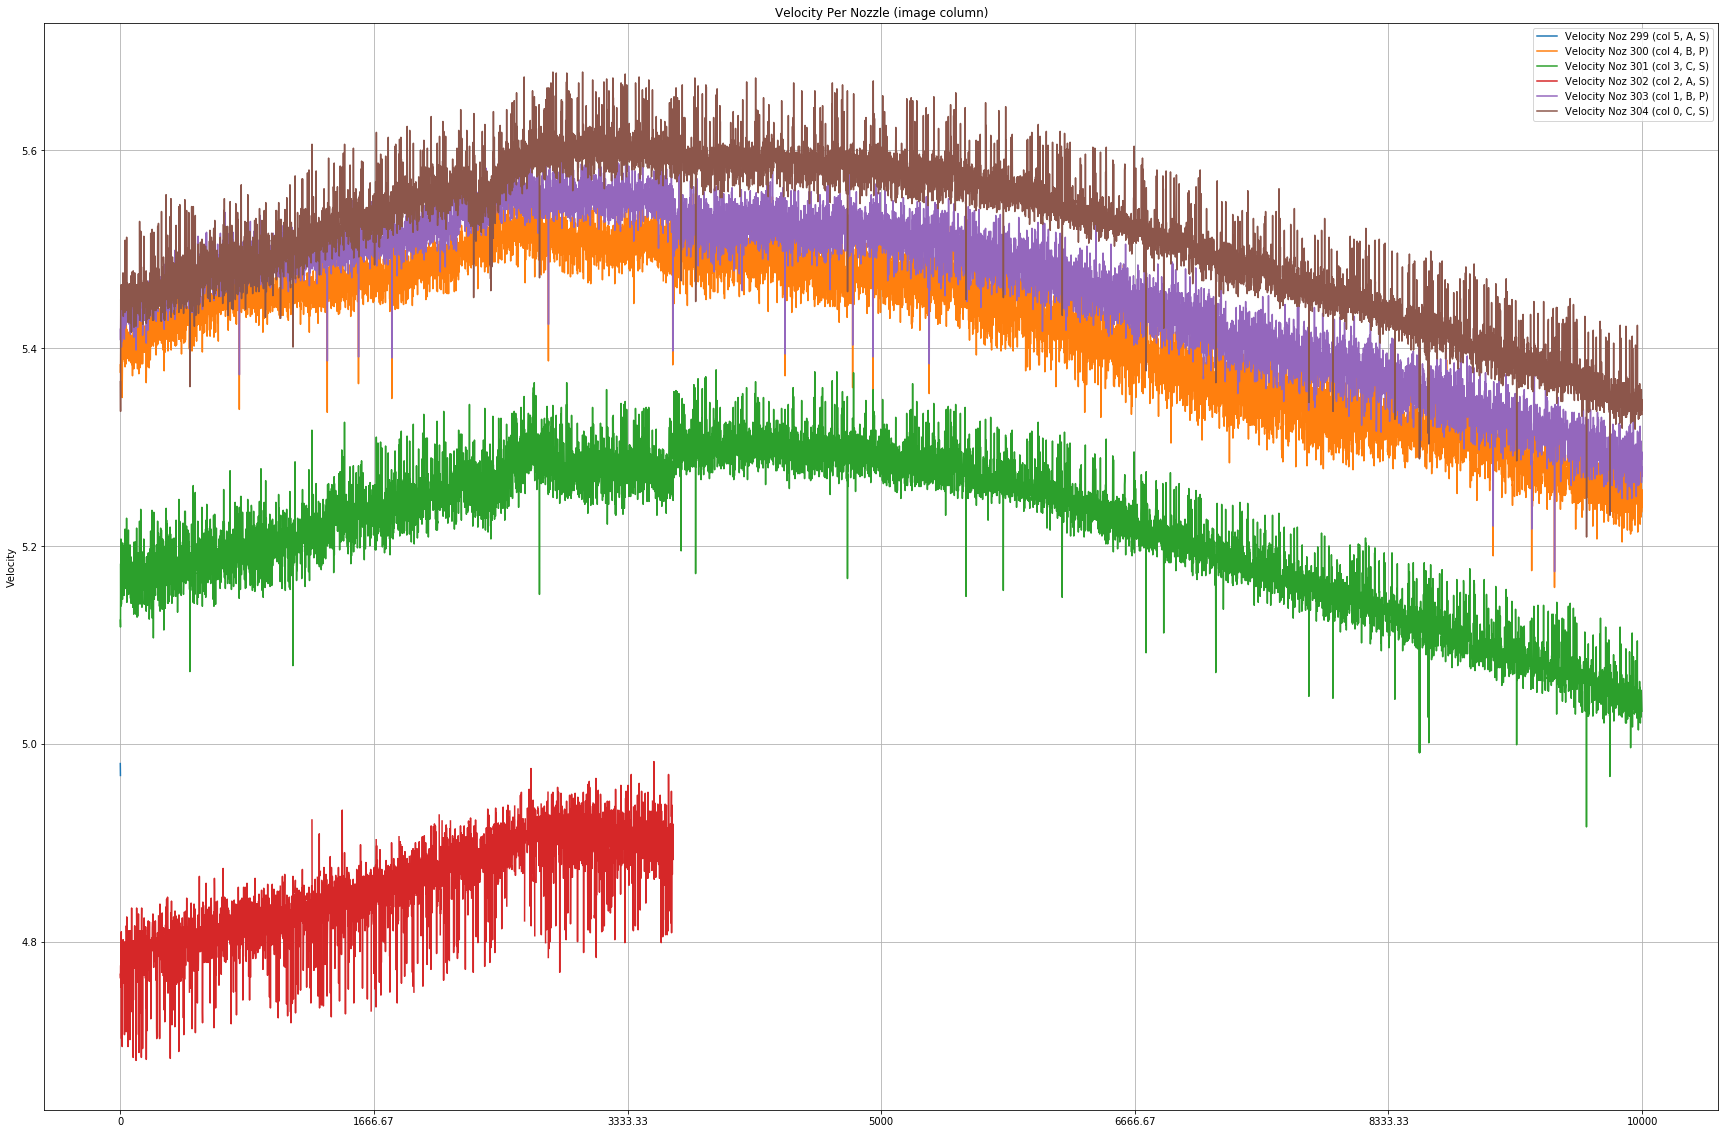

In [85]:
fig, ax = plt.subplots(figsize=(30, 20))
for idx, nozzle in enumerate(nozzle_lst):
    col = ip_results_by_nozzle_df[nozzle].iloc[0]['Column']
    phase = ip_results_by_nozzle_df[nozzle].iloc[0]['Phase']
    primary = ip_results_by_nozzle_df[nozzle].iloc[0]['Primary']
    c = 'P' if primary else 'S'
    #clr = 'blue' if primary else 'gray'
    ip_results_by_nozzle_df[nozzle].loc[ :, ['Velocity']].plot(ax=ax, y='Velocity', label=f"Velocity Noz {nozzle} (col {col}, {phase}, {c})", grid=True)

ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/6))
ax.xaxis.set_major_formatter(ticks_x)
ax.set_ylabel("Velocity")
ax.set_title("Velocity Per Nozzle (image column)")
plt.savefig(f"{result_path}/DIF1_10000cycle_velocity.png")


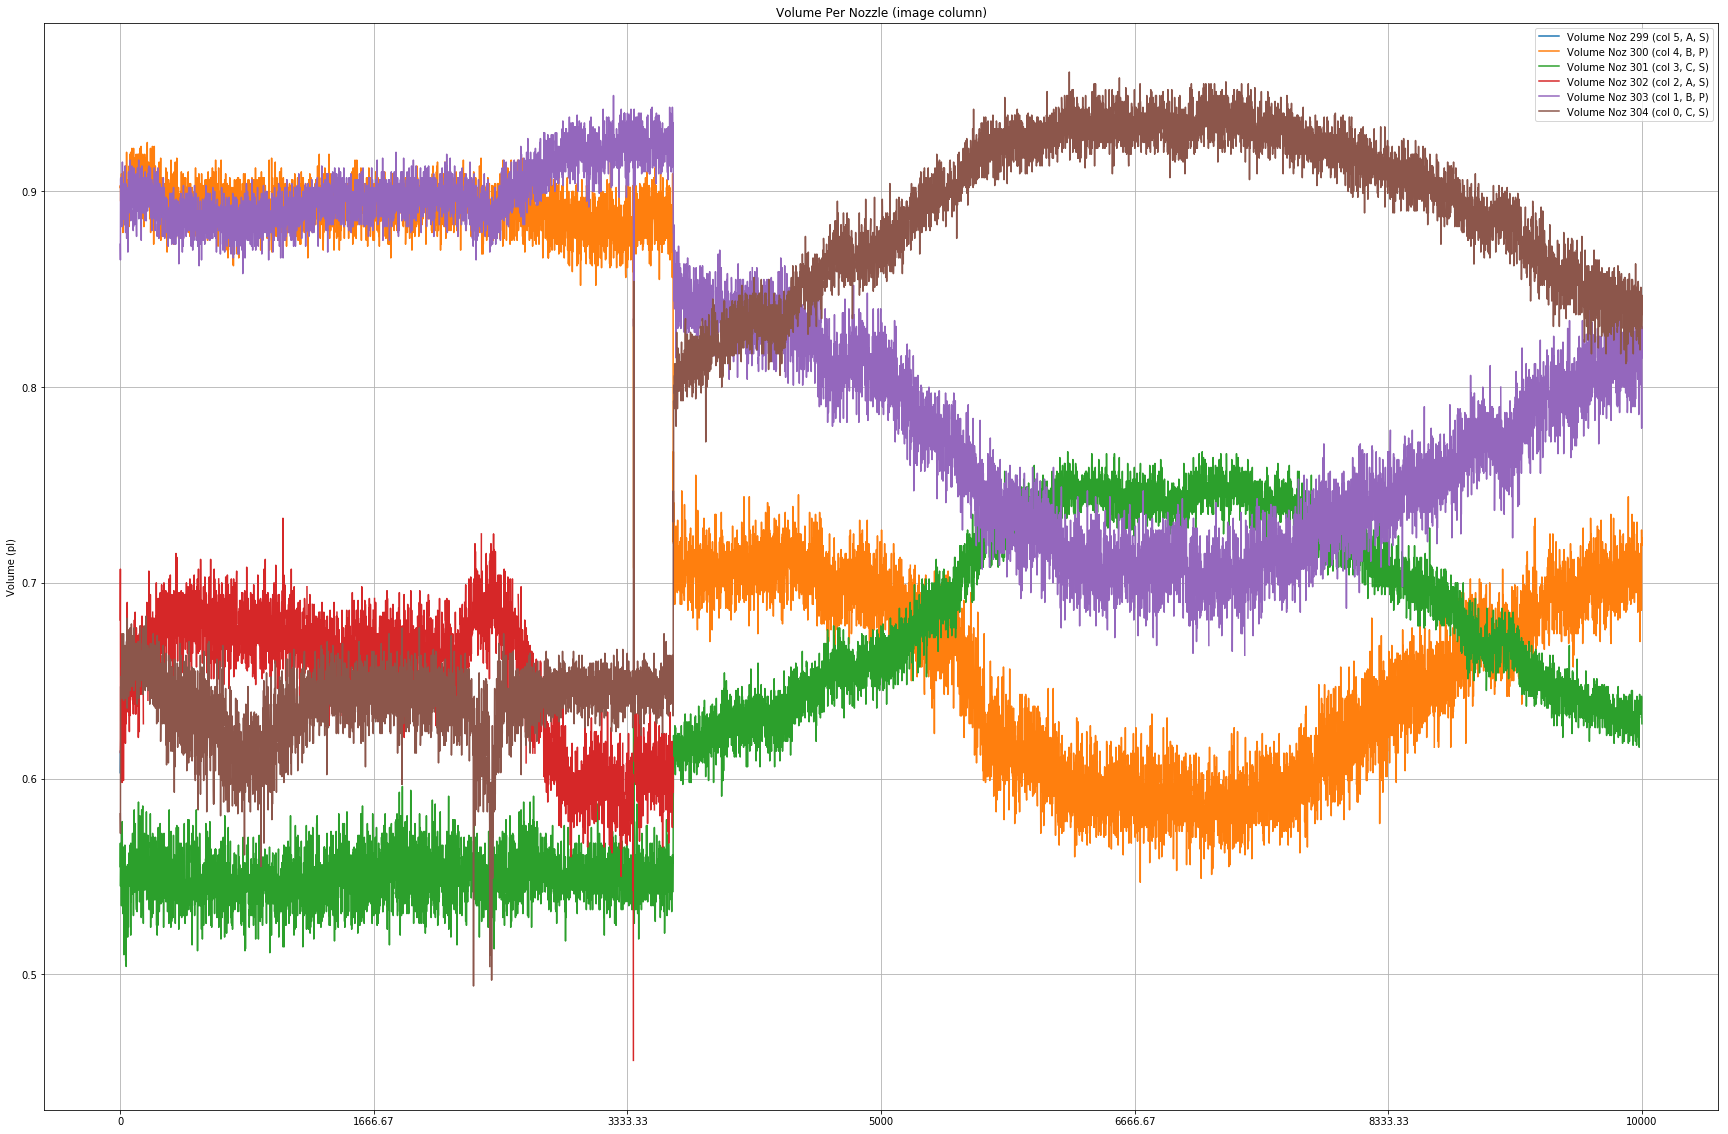

In [110]:
start, end = 21400, 22000
start, end = 0, 60000
fig, ax1 = plt.subplots(figsize=(30, 20))
for idx, nozzle in enumerate(nozzle_lst):
    col = ip_results_by_nozzle_df[nozzle].iloc[0]['Column']
    phase = ip_results_by_nozzle_df[nozzle].iloc[0]['Phase']
    primary = ip_results_by_nozzle_df[nozzle].iloc[0]['Primary']
    c = 'P' if primary else 'S'
    clr = 'blue' if primary else 'gray'
    ip_results_by_nozzle_df[nozzle].loc[ start:end, ['Vol_top']].plot(ax=ax1, y='Vol_top',label=f"Volume Noz {nozzle} (col {col}, {phase}, {c})", grid=True)

ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/6))
ax1.xaxis.set_major_formatter(ticks_x)

ax1.set_ylabel("Volume (pl)")
ax1.set_title("Volume Per Nozzle (image column)")
plt.savefig(f"{result_path}/DIF1_10000cycle_volume.png")


Nozzle
299    AxesSubplot(0.125,0.125;0.775x0.755)
300    AxesSubplot(0.125,0.125;0.775x0.755)
301    AxesSubplot(0.125,0.125;0.775x0.755)
302    AxesSubplot(0.125,0.125;0.775x0.755)
303    AxesSubplot(0.125,0.125;0.775x0.755)
304    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

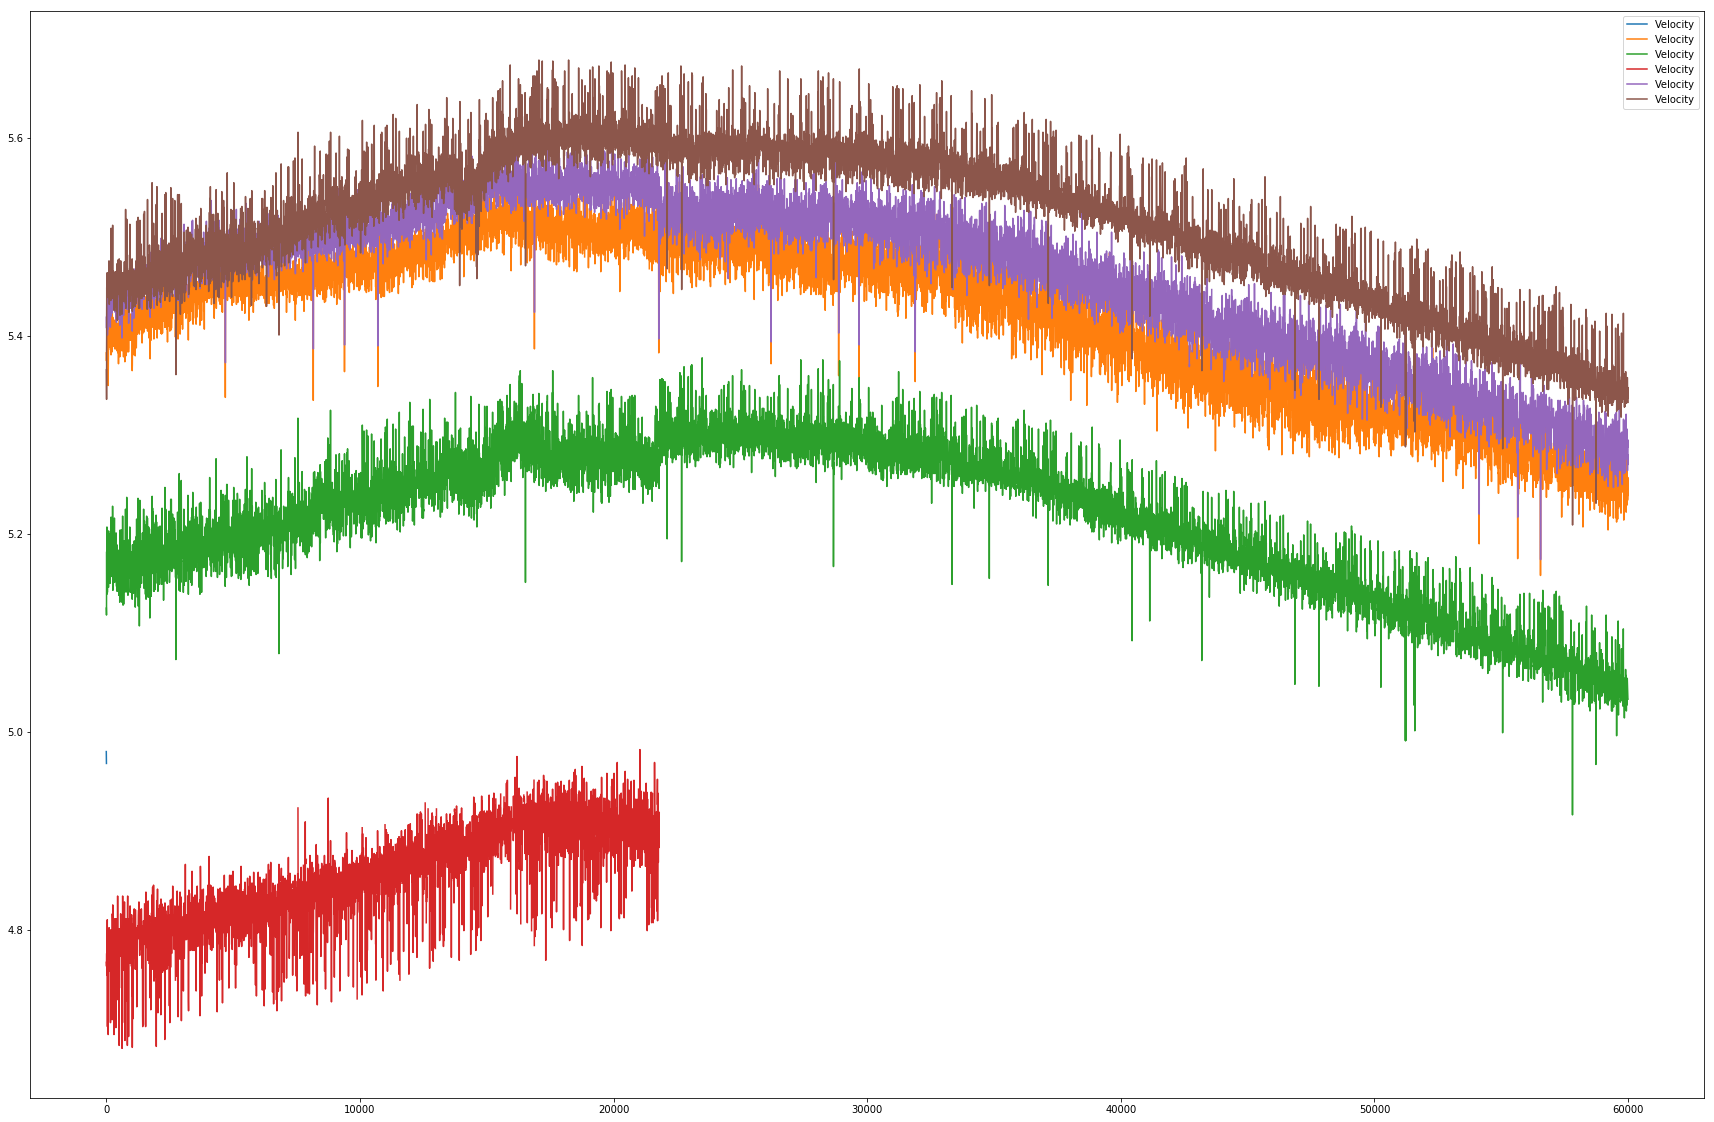

In [45]:
fig, ax1 = plt.subplots(figsize=(30, 20))
grouped_df = ip_results_df.groupby('Nozzle')
grouped_df.plot(y='Velocity', ax=ax1)

In [46]:
noz_302_ip_df = ip_results_by_nozzle_df[302]

In [47]:
noz_302_ip_df.tail()


,LoopID,Repeat,ImageFile,Pattern,Waveform,Voltage,Clock,PD_delay_us,Row,Nozzle,NOI,Phase,Column,Primary,Velocity,Vol_top,Vol_bot
59973,9996,9996.0,/media/DIF_DATA/images/2536865/2019-05-09_10.3...,recipe/miss_fire_test_g32x2_15000lines.bmp,F888_TS_110NS.txt,20.0,120.0,250.0,1,302,False,A,2,False,NaN,NaN,NaN
59979,9997,9997.0,/media/DIF_DATA/images/2536865/2019-05-09_10.3...,recipe/miss_fire_test_g32x2_15000lines.bmp,F888_TS_110NS.txt,20.0,120.0,250.0,1,302,False,A,2,False,NaN,NaN,NaN
59985,9998,9998.0,/media/DIF_DATA/images/2536865/2019-05-09_10.3...,recipe/miss_fire_test_g32x2_15000lines.bmp,F888_TS_110NS.txt,20.0,120.0,250.0,1,302,False,A,2,False,NaN,NaN,NaN
59991,9999,9999.0,/media/DIF_DATA/images/2536865/2019-05-09_10.3...,recipe/miss_fire_test_g32x2_15000lines.bmp,F888_TS_110NS.txt,20.0,120.0,250.0,1,302,False,A,2,False,NaN,NaN,NaN
59997,10000,10000.0,/media/DIF_DATA/images/2536865/2019-05-09_10.3...,recipe/miss_fire_test_g32x2_15000lines.bmp,F888_TS_110NS.txt,20.0,120.0,250.0,1,302,False,A,2,False,NaN,NaN,NaN


In [53]:
noz_302_ip_df['Velocity'].last_valid_index()
#noz_302_ip_df.iloc[idx]['Velocity']

21801

In [59]:
ip_results_df.loc[21801]['ImageFile']

'/media/DIF_DATA/images/2536865/2019-05-09_10.32.02/DispenserOpt_03634_2019-05-09_16.35.13.png'

In [87]:
image_stats_df.head()

,LoopID,ImageFile,Top Saturation,Top Min,Top Max,Top Mean,Bot Saturation,Bot Min,Bot Max,Bot Mean
0,1,/media/DIF_DATA/images/2536865/2019-05-09_10.3...,0.470187,2631,65254,30814.199414,0.378838,2162,65535,24827.537878
1,2,/media/DIF_DATA/images/2536865/2019-05-09_10.3...,0.471469,2692,65535,30898.204485,0.375421,2210,65515,24603.591136
2,3,/media/DIF_DATA/images/2536865/2019-05-09_10.3...,0.461924,2704,65535,30272.637928,0.381119,2434,65443,24977.029797
3,4,/media/DIF_DATA/images/2536865/2019-05-09_10.3...,0.458772,2825,65535,30066.097748,0.381409,2486,65278,24995.994272
4,5,/media/DIF_DATA/images/2536865/2019-05-09_10.3...,0.465921,2889,65535,30534.619410,0.375223,2465,65491,24590.647152


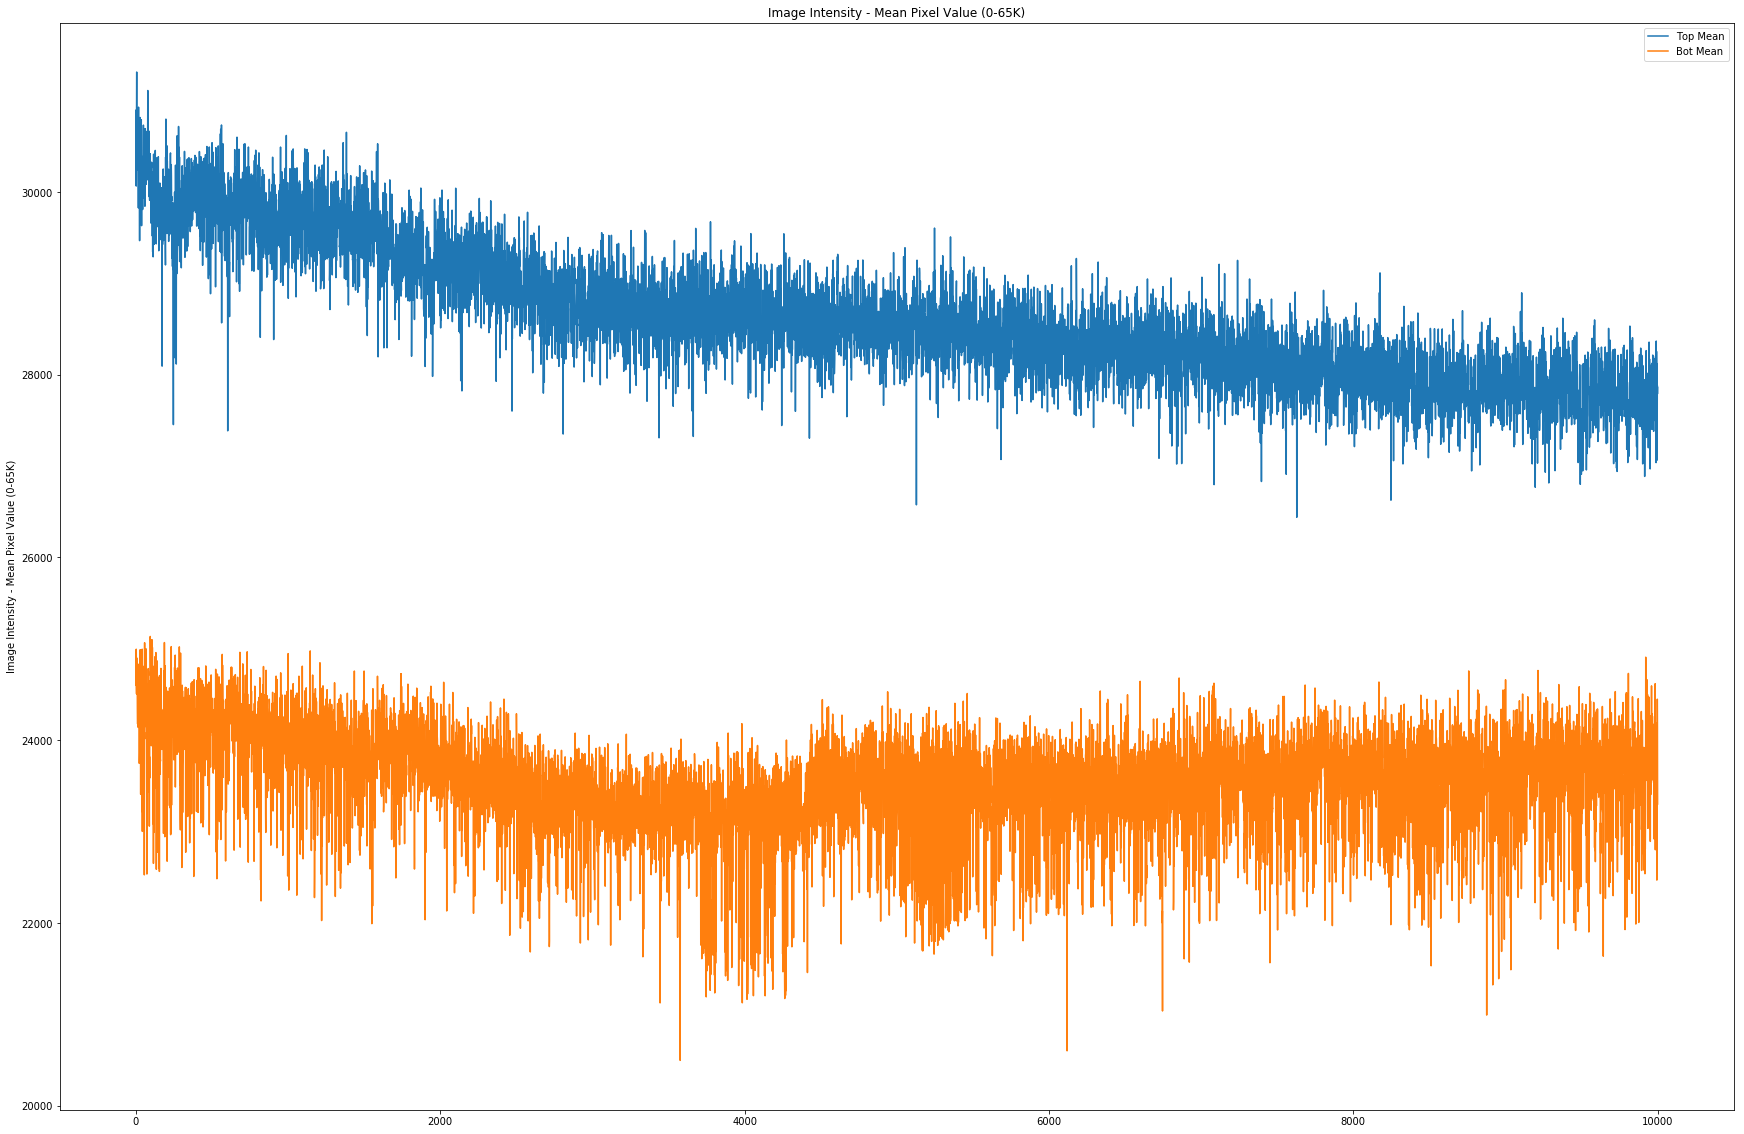

In [115]:
col_lst = ['Top Mean', 'Bot Mean']

fig, ax1 = plt.subplots(figsize=(30, 20))
for idx, col_name in enumerate(col_lst):
    image_stats_df[col_name].plot(ax=ax1, y=col_name, label=col_name)

ax1.set_ylabel("Image Intensity - Mean Pixel Value (0-65K)")
ax1.set_title("Image Intensity - Mean Pixel Value (0-65K)")
plt.legend()
plt.savefig(f"{result_path}/DIF1_10000cycle_imageIntensity.png")
plt.show()